In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, RocCurveDisplay)
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [6]:
df = pd.read_csv('flu.csv')

In [18]:
def handle_missing_data(df):
    # Penanganan nilai numerik
    num_cols = ['Age', 'Temperature']
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
    
    # Daftar semua kolom kategorikal biner
    binary_cols = [
        'GroundGlassOpacity', 'Diarrhea', 'Fever', 
        'Coughing', 'ShortnessOfBreath', 'SoreThroat',
        'NauseaVomitting', 'Fatigue'
    ]
    
    # Penanganan nilai kategorikal
    for col in binary_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
        df[col] = df[col].map({'Yes': 1, 'No': 0})
    
    # Penanganan RiskFactors
    df['RiskFactors'] = df['RiskFactors'].fillna('').astype(str)
    df['RiskFactors'] = df['RiskFactors'].apply(
        lambda x: [item.strip() for item in x.split(',') if item.strip()]
    )
    
    risk_factors = set()
    for sublist in df['RiskFactors']:
        risk_factors.update(sublist)
    risk_factors = [x for x in risk_factors if x]

    for factor in risk_factors:
        df[f'Risk_{factor}'] = df['RiskFactors'].apply(
            lambda x: 1 if factor in x else 0
        )

    return df.drop(columns=['RiskFactors'], axis=1)

df = handle_missing_data(df)

In [22]:
X = df.drop(['Diagnosis', 'InitialPCRDiagnosis', 'CTscanResults'], axis=1)
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)  # Tambahan validasi
y = df['Diagnosis']


In [23]:
#split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

C:\Users\bimod\AppData\Local\Temp\ipykernel_1544\2427561747.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=symptom_counts.values, y=symptom_counts.index, palette='viridis')
C:\Users\bimod\AppData\Local\Temp\ipykernel_1544\2427561747.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_counts.values, y=risk_counts.index, palette='rocket')
C:\Users\bimod\AppData\Local\Temp\ipykernel_1544\2427561747.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diagnosis', y='Temperature', data=df, palette='Set2')


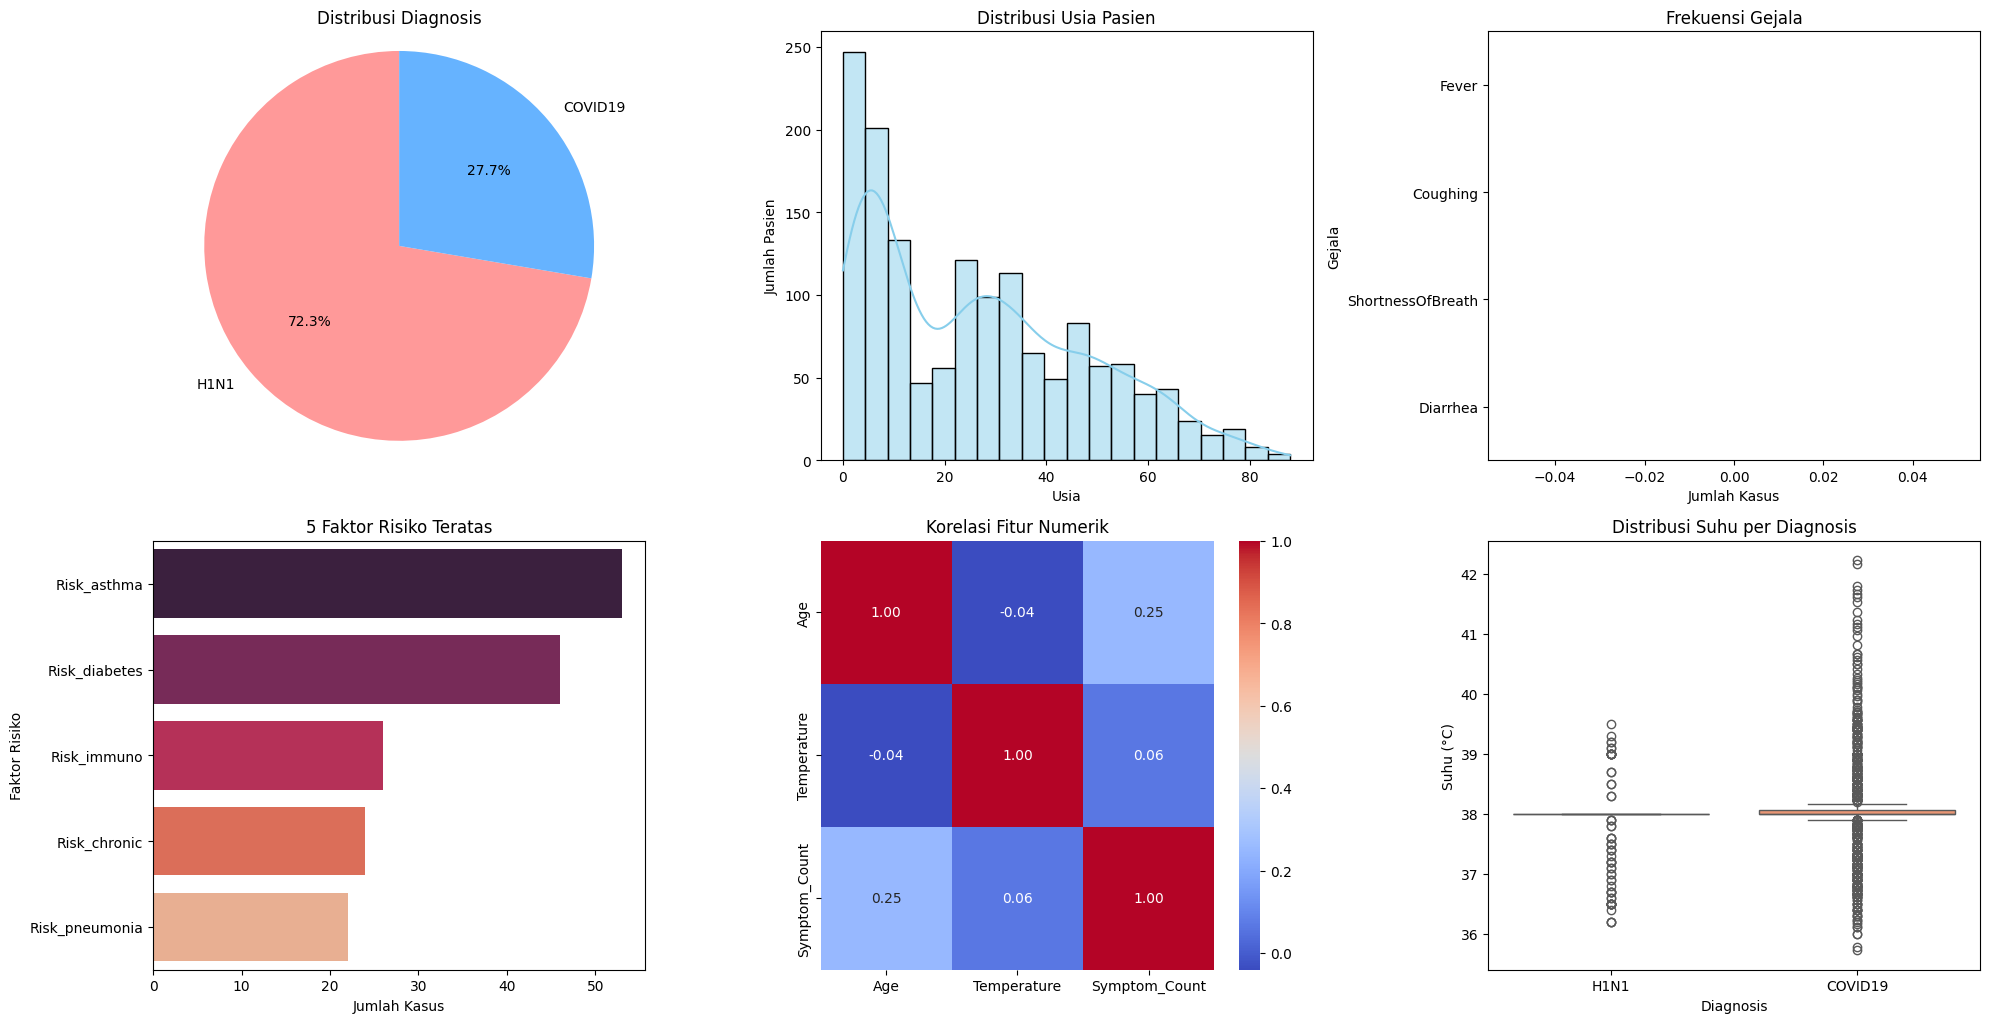

In [24]:
plt.figure(figsize=(20, 15))

# Plot 1: Distribusi Diagnosis
plt.subplot(3, 3, 1)
diagnosis_counts = df['Diagnosis'].value_counts()
plt.pie(diagnosis_counts, labels=['H1N1', 'COVID19'], autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff'], startangle=90)
plt.title('Distribusi Diagnosis', fontsize=12)
plt.axis('equal')

# Plot 2: Distribusi Usia
plt.subplot(3, 3, 2)
sns.histplot(data=df, x='Age', kde=True, bins=20, color='skyblue')
plt.title('Distribusi Usia Pasien', fontsize=12)
plt.xlabel('Usia')
plt.ylabel('Jumlah Pasien')

# Plot 3: Gejala Utama
plt.subplot(3, 3, 3)
symptoms = ['Fever', 'Coughing', 'ShortnessOfBreath', 'Diarrhea']
symptom_counts = df[symptoms].sum().sort_values(ascending=False)
sns.barplot(x=symptom_counts.values, y=symptom_counts.index, palette='viridis')
plt.title('Frekuensi Gejala', fontsize=12)
plt.xlabel('Jumlah Kasus')
plt.ylabel('Gejala')

# Plot 4: Faktor Risiko
plt.subplot(3, 3, 4)
risk_cols = [col for col in df.columns if col.startswith('Risk_')]
risk_counts = df[risk_cols].sum().sort_values(ascending=False).head(5)
sns.barplot(x=risk_counts.values, y=risk_counts.index, palette='rocket')
plt.title('5 Faktor Risiko Teratas', fontsize=12)
plt.xlabel('Jumlah Kasus')
plt.ylabel('Faktor Risiko')

# Plot 5: Heatmap Korelasi
plt.subplot(3, 3, 5)
corr_matrix = df[['Age', 'Temperature', 'Symptom_Count']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi Fitur Numerik', fontsize=12)

# Plot 6: Distribusi Suhu
plt.subplot(3, 3, 6)
sns.boxplot(x='Diagnosis', y='Temperature', data=df, palette='Set2')
plt.title('Distribusi Suhu per Diagnosis', fontsize=12)
plt.xticks([0, 1], ['H1N1', 'COVID19'])
plt.xlabel('Diagnosis')
plt.ylabel('Suhu (°C)')

plt.tight_layout()
plt.show()


In [ ]:
#Handle Class Imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [27]:
# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [28]:
#Evaluasi Model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nEvaluation Metrics:")
print(f"Akurasi: {accuracy_score(y_test, y_pred):.2f}")
print(f"Presisi: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83        90
           1       0.93      0.91      0.92       207

    accuracy                           0.89       297
   macro avg       0.87      0.88      0.87       297
weighted avg       0.89      0.89      0.89       297


Confusion Matrix:
[[ 76  14]
 [ 18 189]]

Evaluation Metrics:
Akurasi: 0.89
Presisi: 0.93
Recall: 0.91
F1-Score: 0.92
AUC-ROC: 0.93


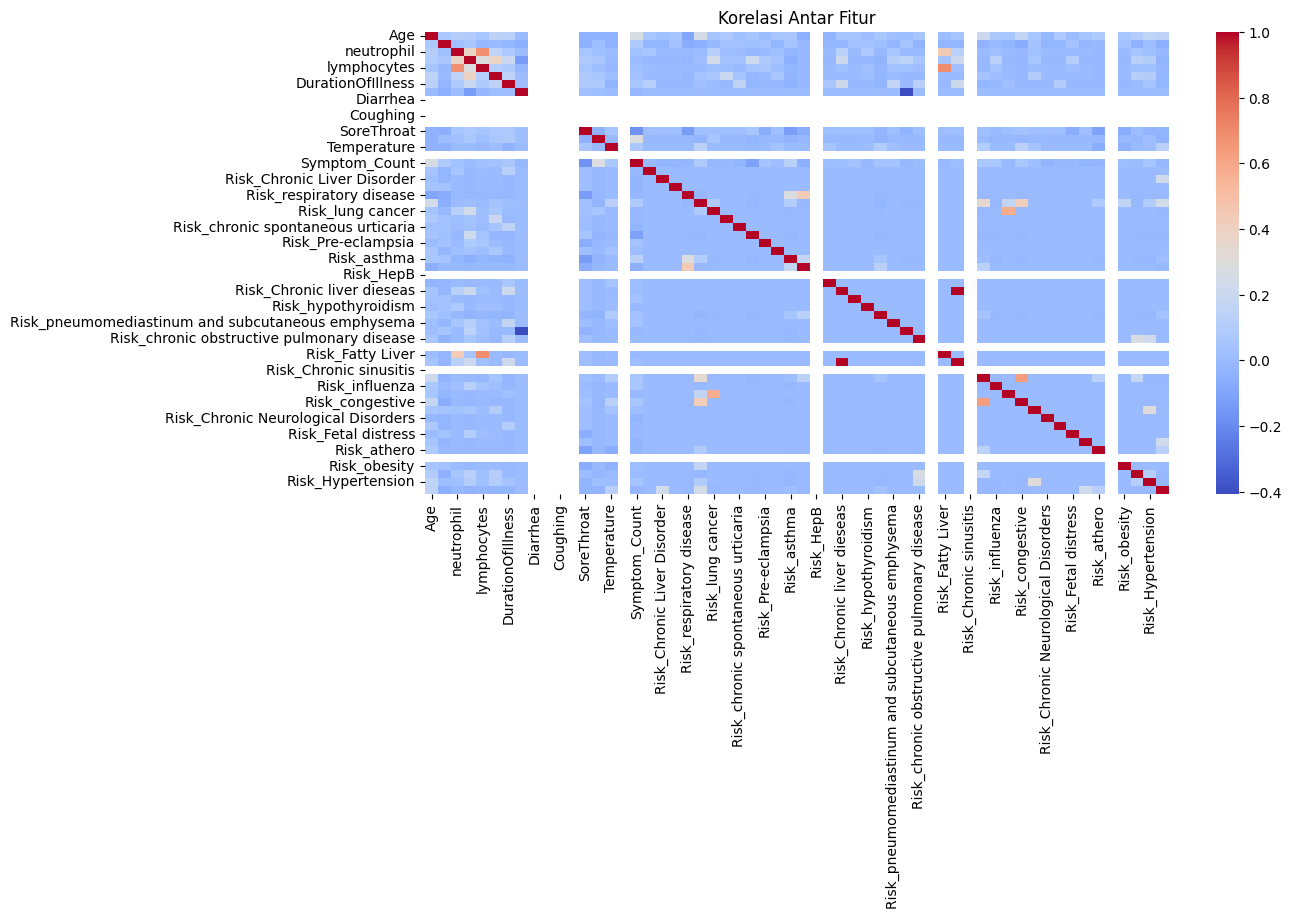

In [29]:
#Visualisasi
plt.figure(figsize=(12, 6))
sns.heatmap(X_train.corr(), cmap='coolwarm')
plt.title('Korelasi Antar Fitur')
plt.show()

**Penjelasan Persamaan Matematika**
  Berikut penjelasan untuk setiap metrik evaluasi yang digunakan:

  a. Akurasi (Accuracy)
  
  ![akurasi.png](attachment:image.png)

   - TP (True Positive): Prediksi benar kelas positif.

   - TN (True Negative): Prediksi benar kelas negatif.

   - FP (False Positive): Prediksi salah kelas positif.

   - FN (False Negative): Prediksi salah kelas negatif.

   - Interpretasi: Persentase prediksi yang benar dari total prediksi.

  b. Presisi (Precision)
  
  ![presisi.png](attachment:image-2.png)

  - Interpretasi: Proporsi prediksi positif yang benar. Tinggi jika sedikit false positive.

  c. Recall (Sensitivity)

  ![recall.png](attachment:image-3.png)

  - Interpretasi: Proporsi instance positif yang terdeteksi. Tinggi jika sedikit false negative.

  d. F1 Score

  ![f1.png](attachment:image-4.png)

  - Interpretasi: Rata-rata harmonik presisi dan recall. Berguna jika kelas tidak seimbang.

  e. AUC-ROC (Area Under Curve - Receiver Operating Characteristic)
  - ROC Curve: Plot True Positive Rate (Recall) vs False Positive Rate (FPR = FP / (FP + TN)).

  - AUC: Luas di bawah kurva ROC. Nilai 1 = sempurna, 0.5 = acak.

  - Interpretasi: Kemampuan model membedakan kelas positif dan negatif.

  f. ROC Curve
  Dibuat dengan memvariasikan threshold klasifikasi dan menghitung TPR vs FPR.